# Pluton emplacement test

This Jupyter notebook employs the stochastic sampling algorithm of [Keller, Schoene, and Samperton (2018)](https://doi.org/10.7185/geochemlet.1826) as implemented in [Chron.jl](https://github.com/brenhinkeller/Chron.jl).

<a href="https://mybinder.org/v2/gh/brenhinkeller/Chron.jl/master?filepath=examples%2FPlutonEmplacement.ipynb" target="_blank"><img src="https://static.mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***

## Load required Julia packages

In [1]:
# Load (and install if necessary) the Chron.jl package
try
    using Chron
catch
    using Pkg
    Pkg.add(PackageSpec(url="https://github.com/brenhinkeller/Chron.jl"))
    using Chron
end

using Statistics, StatsBase, DelimitedFiles, SpecialFunctions
using KernelDensity: kde
using Plots; gr(); default(fmt = :png)

***
## Estimate the time of rheological lockup 
Given that the rheologically critical melt fraction ≈ 36% melt (see, e.g., [Caricchi 2007](https://doi.org/10.1016/j.epsl.2007.09.032) for experimental rheological data), which is also approximately the terminal porosity of a framework of close-packed spheres, a body of magma may be considered effectively "emplaced" by the time it cools to where F $\leq$ 0.36. 

If we estimate the point within a MELTS zircon saturation distribution where melt fraction drops below 36%, we can use this to estimate the time by which a body of magma must have been emplaced.

#### Input dataset (Try pasting in your own data here!)

In [2]:
# Age and one-sigma uncertainty.
ages = [101.333, 102.175, 102.074, 102.814, 102.335, 101.212, 101.398, 101.772, 102.456, 102.302, 102.039, 101.579, 102.135, 101.978, 102.325, 102.36, 101.53, 102.409, 101.277, 102.766,]
uncert = [0.137, 0.141, 0.134, 0.149, 0.132, 0.141, 0.129, 0.129, 0.135, 0.142, 0.144, 0.128, 0.15, 0.144, 0.132, 0.13, 0.133, 0.133, 0.148, 0.14,]

# Sort by age (just to make rank-order plots prettier)
t = sortperm(ages)
ages = ages[t];
uncert = uncert[t];

#### Input MELTS-derived $\ \mathcal{\vec{f}}_{xtal}(t_r)$

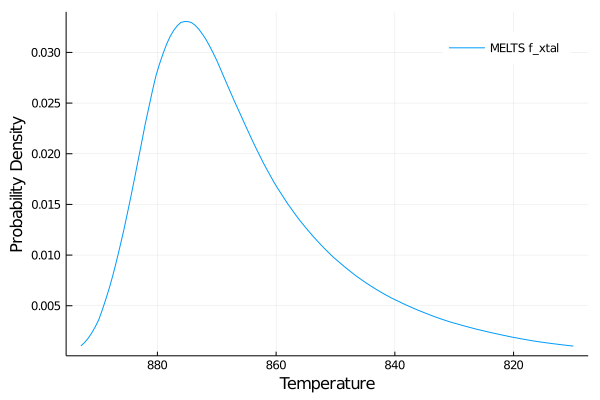

In [3]:
# Distribution, AKA MZrn
dist = [0.00102226,0.00105785,0.00109886,0.00113827,0.00118283,0.00122527,0.00127,0.00131584,0.00136402,0.00141291,0.00146517,0.00151593,0.0015771,0.00163667,0.00169765,0.00176478,0.00183148,0.00189186,0.00196526,0.00203994,0.00211244,0.00219109,0.00226588,0.00234415,0.00242908,0.00250853,0.00259262,0.00267285,0.00276366,0.00285942,0.00295,0.00304668,0.0031507,0.00324811,0.00334256,0.00345641,0.00357056,0.00368579,0.00381205,0.00393925,0.0040682,0.00420839,0.00434517,0.00448705,0.00462617,0.00478174,0.00494046,0.00509347,0.005262,0.00543599,0.00559582,0.00576977,0.00596128,0.00615107,0.00635583,0.00656449,0.00678063,0.00700385,0.00723641,0.00747424,0.00772279,0.00797097,0.00824662,0.00852537,0.00880685,0.00910631,0.00941175,0.00970515,0.0100419,0.0103883,0.0107337,0.0111116,0.0114879,0.0118724,0.0122876,0.0127015,0.0131353,0.0135732,0.0140491,0.0145477,0.0150343,0.0155732,0.0161175,0.0166661,0.0172398,0.0178859,0.018519,0.0191786,0.0198861,0.0206008,0.0213348,0.0221012,0.0228635,0.0236548,0.0244204,0.025197,0.0260081,0.0268075,0.0276271,0.0284577,0.0292575,0.0299837,0.0306664,0.0313003,0.0318339,0.0323055,0.03268,0.0329388,0.0330462,0.0330452,0.0329532,0.0326285,0.032175,0.0315716,0.0308023,0.0298608,0.0288332,0.0276613,0.0261425,0.0245284,0.0228927,0.0210703,0.0192917,0.0175039,0.015764,0.01409,0.0124369,0.0109181,0.00945112,0.00806163,0.00679755,0.00566667,0.0045914,0.0036195,0.00290947,0.00229281,0.00177751,0.0013579,0.0010393,]
# Corresponding MELTS temperatures. 
T = [809.92,810.521,811.122,811.723,812.325,812.926,813.527,814.128,814.729,815.331,815.932,816.533,817.134,817.735,818.337,818.938,819.539,820.14,820.741,821.343,821.944,822.545,823.146,823.747,824.349,824.95,825.551,826.152,826.754,827.355,827.956,828.557,829.158,829.76,830.361,830.962,831.563,832.164,832.766,833.367,833.968,834.569,835.17,835.772,836.373,836.974,837.575,838.176,838.778,839.379,839.98,840.581,841.182,841.784,842.385,842.986,843.587,844.188,844.79,845.391,845.992,846.593,847.194,847.796,848.397,848.998,849.599,850.2,850.802,851.403,852.004,852.605,853.206,853.808,854.409,855.01,855.611,856.212,856.814,857.415,858.016,858.617,859.218,859.82,860.421,861.022,861.623,862.224,862.826,863.427,864.028,864.629,865.23,865.832,866.433,867.034,867.635,868.236,868.838,869.439,870.04,870.641,871.242,871.844,872.445,873.046,873.647,874.248,874.85,875.451,876.052,876.653,877.255,877.856,878.457,879.058,879.659,880.261,880.862,881.463,882.064,882.665,883.267,883.868,884.469,885.07,885.671,886.273,886.874,887.475,888.076,888.677,889.279,889.88,890.481,891.082,891.683,892.285,892.886,]
# Both of the above must be in order of increasing temperature (=increasing age)
# We are implicitly assuming a constant cooling rate by treating a 
# scaled temperature distribution as equivalent to a scaled time distribution

# Plot distribution
plot(T, dist, label="MELTS f_xtal", ylabel="Probability Density", xlabel="Temperature", xflip=true, fg_color_legend=:white)

#### Run MCMC to estimate eruption age

In [4]:
# Configure model
nsteps = 400000; # Length of Markov chain
burnin = 150000; # Number of steps to discard at beginning of Markov chain

# Run MCMC
(tminDist, tmaxDist, llDist, acceptanceDist) = metropolis_minmax(nsteps,dist,ages,uncert; burnin=burnin);

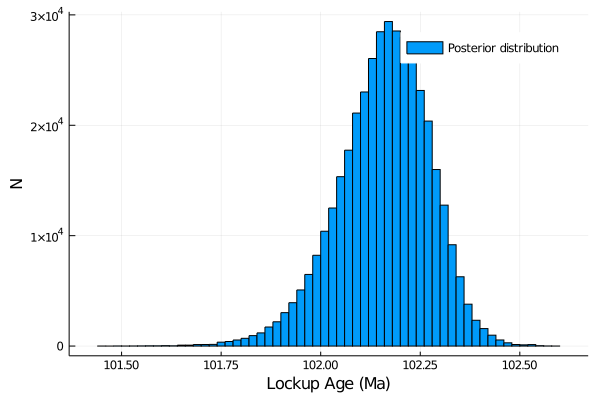


Estimated lockup age:
 102.15860590819538 +/- 0.2307547538943845 Ma (2σ)


In [5]:
# The fraction of the way through the MELTS dist that lockup occurs
lockup_fraction_mu = 0.2814311218465038 
lockup_fraction_sigma = 0; #0.07475159714446021

lockup_fraction = lockup_fraction_mu .+ lockup_fraction_sigma .* randn(size(tminDist))
lockup_dist = tmaxDist .* (1 .- lockup_fraction) .+ tminDist .* lockup_fraction

# Print results
AgeEst = mean(lockup_dist)
AgeEst_sigma = std(lockup_dist)
print("\nEstimated lockup age:\n $AgeEst +/- $(2*AgeEst_sigma) Ma (2σ)\n")

# Plot results
h = histogram(lockup_dist,nbins=100,label="Posterior distribution",xlabel="Lockup Age (Ma)",ylabel="N",fg_color_legend=:white)
# plot!(h,[wx,wx],collect(ylims()),line=(3),label="Weighted mean age",legend=:topleft)
display(h)
sleep(0.5)

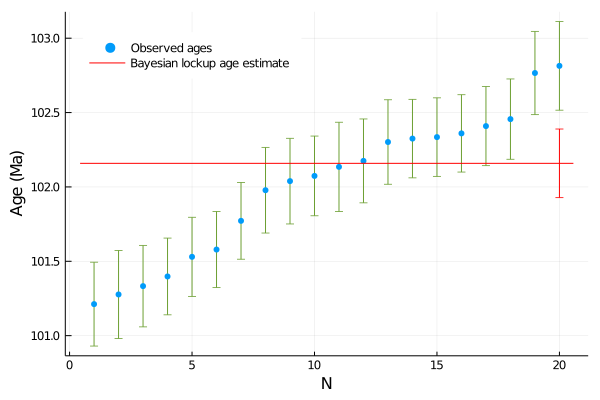

In [6]:
# Plot eruption age estimate relative to rank-order plot of raw zircon ages
h = plot(ylabel="Age (Ma)", xlabel="N", legend=:topleft, fg_color_legend=:white)
plot!(h,1:length(ages),ages,yerror=uncert*2,seriestype=:scatter, markerstrokecolor=:auto, label="Observed ages")
plot!(h,[length(ages)],[AgeEst],yerror=2*AgeEst_sigma, markerstrokecolor=:auto, label="Bayesian lockup age estimate",color=:red)
plot!(h,collect(xlims()),[AgeEst,AgeEst],color=:red, label="")

***